# Topic Modelling of Danish Parliament Transcripts

## Table of Contents

* Pre-face and Introduction
* Data
    * Data Preprocessing
    * Synthetic Data
* Latent Dirichlet Allocation
    * Pyro Implementation (måske forklar guiden en smule bedre, not sure how to)
    * Amortized Pyro Implementation
    * Pyro Results (MANGLER, show syntetisk)
    * LDA on full data set using the Gensim Library (UDDYB SPECIFICATIONS, why do we use 25 topics etc, why use TFIDF, why choosing a block size of 2000?)
    * Gensim Results
* Dynamic Topic Modelling
    * Theory
    * Pyro Implementation (MANGLER, i'll fix that)
    * Training
    * Results
* Discussion (MANGLER)
* Conclusion and Future Work (MANGLER)
* Sources (MANGLER)

(LÆS IGENNEM, RET STAVEFEJL OG CLEAN CODE/UDDYB) (LAV RAPPORT)

In [ ]:
# Do the imports
import gc
gc.collect()

import argparse
import functools
import logging

import numpy as np
import pandas as pd
import os
from pathlib import Path
import sys
from scipy import stats
import pickle
import scipy
import time
from collections import defaultdict
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("whitegrid")

import torch
from torch import nn
from torch.distributions import constraints
import functools

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta
from pyro.optim import ClippedAdam
from pyro import sample , poutine , plate , param

from gensim import corpora
from gensim.models import LdaModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim import corpora, utils

## Pre-face
This notebook independently shows our final project for 42186 Model-Based Machine Learning. Additional info and results can be found in our report which has been handed in as an appendix.

All obtained outputs are shown in the notebook but it can not run again without having all data ready. If you wish to work with this notebook go to following repository:

https://github.com/MikkelGroenning/MBML_project_generate_data

This includes two python scripts that can be used to get the data and preprocess it as we have done. Opening the notebook from this repository after having run these scripts should allow this notebook to be edited. See the readme for more info.

## Introduction

In this project we will use topic modelling to investigate topics dicussed in the Danish Parliment between 2009 and 2017. The overall goal is to find temporal evolutions in the topics discussed in the parliment by using dynamic topic models (DTM). As a simpler start we witll use latent dirichlet allocation (LDA) to extract some topics over the full time period. We use freely available transcripts from the Danish Parliment in the given time-period for our analysis.

# Data
In this part we will give an overview of the data, how to get it and how we preprocessed it to suit out needs.

### Raw Data

The raw data consists of 10 XML-files taking up roughly 300 MB, which can be found here: 

https://repository.clarin.dk/repository/xmlui/handle/20.500.12115/8

The data contains complete transcripts of parliamentary speeches from October 2009 through May 2017. To each speech there are information about when it was said, who said it with name, party and role in the parliment, what agenda point was dicussed and what was acutally said. More features were available which had no relevance to us. The raw data consists of approximately 380.000 observations (speeches) with roughly 40 million words in total.

### Getting the data

The data can be downloaded from the link above. We have though made it easier to get started by using the python script `makedata.py` (see the github mention in the pre-face) to automatically download the data and set it up correctly to our needs (only extracting relevant features). The resulting data frame can then be preprocessed as explaiend below.


### Preproccesing of the data

After having the data preproccesing was needed. We spend in total 15-20 hours on this and all the code can all be found in the script `buildfeatures.py` (see the github mention in the pre-face). A brief overview of what was done is shown below:

1. Remove all speeches from the speaker as this person acts a mediator in the parliment. This approximately halves the number of speeches.

2. Label party for all speeches. If members are in office for a given speech. their party is labeled as NA. We have filled all these manually.

3. Merging North Atlantic parties. In the parliment are small North Atlantic parties. They are merged into one so they have a bit more represented.

4. Merging speeches from same party within same agenda point. In order to reduce dimensions we did this merging under the assumption that a party have a same feeling about the topic discussed within an agenda point even though they have multiple speeches. This reduced the number of observations with about a factor 6 - but it made the speeches longer.

5. For all speeches we removed stopwords and stemmed the words. 

6. Convert all speeched to a bag-of-words representation and only keep words that are said a minimum of 50 times.

7. Remove 'common words' which we define as words used in at least 40% of the agenda point discussed in parliment. These words can be seen as domain specific stop words.

8. Perform term frequency–inverse document frequency (tf-idf) to have a _weighting_ for words.

With these measures in place the data is ready which can be loaded after running the `buildfeatures.py` script:

In [1]:
# Data import
sys.path.append('..')
from src.features.build_features import processed_path
from src.features.build_features import df, vocabulary, X, X_tfidf, corpus, corpus_tfidf

With this import we have the following: 

- **df**: Dataframe with 33734 observations including the date of a speech, agenda point, party and the raw text of what was said.

- **vocabulary**: Dictionary which maps word indicies to their corresponding word.

- **X**: Bag of words representation of each speech. The vocabulary length is 23203.

- **X_tfidf**: X with tfidf performed.

- **corpus**: A list of lists where each list correspond to an speech. Each of these lists contains tuples where each tuple corresponds to a word and how many times it was said.

- **corpus**: Same as above but instead of summing the X matrix it is done by summing X_tfidf.

# Synthetic data

The actual data set is very large and when running the Pyro-models on the full dataset we run into time and memory issues of the optimization. We have therefore created a much smaller synthetic dataset which can be used in the Pyro-models we have created. There are Python-libraries that has implemented LDA and DTM much more efficient that is possible to use on the real data that we can use to extract some real results. The synthetic data can then be used to demontrate the functionality of the Pyro-models.


The following blocks of code will generate synthetic documents belonging to a given topic across 100 time stamps. A total of five topics will be used to create the data. Firstly the probability of each topic for each timestamp is generated. The probabilities have to sum to 1 so it corresponds to all topics discussed. For the first time stamp a non-uniform dirichlet is used as this ensures that the probabilities sum top 1. When propegating forward in time autocorrelation is desired as this would be expected in the real parliment. Therefore a new probability for a given topic is drawn from a normal distribution with mean equaling the previous probability. Due to the stochastic element of the normal distribution some new probabilities can end up negative which is problematic. Therefore, if any probabilities are negative a random constant (based on a uniform distribution) is added to make all numbers positive. Lastly the data is normalized for each time stamp so the numbers corresponds to probabilities. Below the cell a plot of the probabilities over time can be seen.

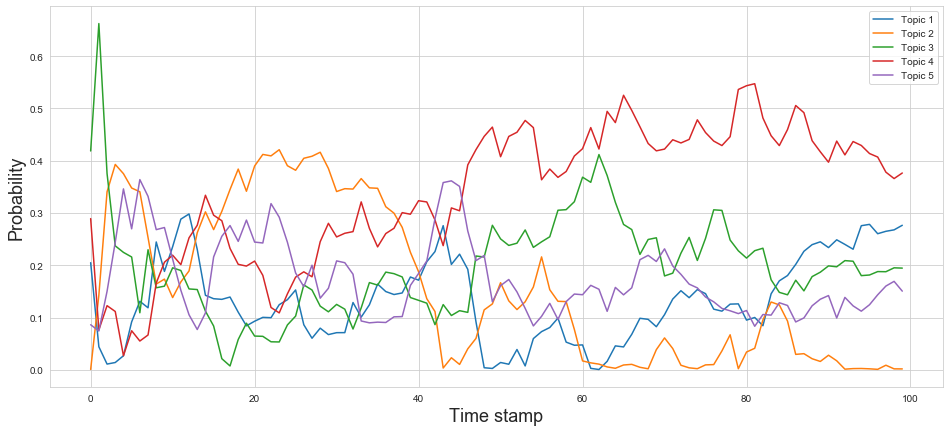

In [2]:
# Set seed
np.random.seed(123)

# Set number of topics, words per topic and time points
topics = 5
word_topic = 25
T = 100

# Initialize time series and first time step using dirichlet
time_series = np.zeros((T,topics))
time_series[0,:] = np.random.dirichlet(np.array([0.2,0.2,0.3,0.5,0.4]))

# Fill remaining time points
for i in range(1,T):
    
    # Use previous time stamp to create new one
    tmp = np.random.normal(loc = time_series[i-1,:], scale=1)
    
    # Make sure no negative values
    if tmp.min() < 0:
        tmp+= np.random.uniform(-1.2*tmp.min(),-1.5*tmp.min())
        
    # Append new time stamp
    time_series[i,:] = tmp

# Normalizae time series
time_series = time_series / time_series.sum(axis=1).reshape(-1,1)

# Visualize the time series
plt.figure(figsize = (16,7))
plt.plot(time_series)
plt.xlabel("Time stamp", fontsize = 18)
plt.ylabel("Probability", fontsize = 18)
plt.legend(('Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'))
plt.show()

Now we need to have a list of words and corresponds probabilties for it beloing to each topic. 25 words *fits* each topic for a total of 125 words. For each word the probability for it corresponds to its main topic is drawn from a uniform distribution with a lower bound of 0.7 and upper bound of 0.3. The remaining probabilities for the other topics are drawn from a sparse dirichlet, which is normalised so the sum of probabilities for each word sum up to 1.

In [3]:
# Initialize matrix
word_prob = np.zeros((word_topic*topics,5))

# Fill out probabilities of main words
for i in range(topics):
    word_prob[i*word_topic:(i+1)*word_topic,i] = np.random.uniform(0.7,0.9,word_topic)
    
    
# Fill the remaining 
for i in range(word_topic*topics):
    if i < word_topic:
        diff = (1-word_prob[0:word_topic, 0]).reshape(-1,1)
        fill = np.random.dirichlet(np.array([0.3, 0.3, 0.3, 0.3]), size = word_topic) * diff
        
        word_prob[0:word_topic, 1] = fill[:, 0]
        word_prob[0:word_topic, 2] = fill[:, 1]
        word_prob[0:word_topic, 3] = fill[:, 2]
        word_prob[0:word_topic, 4] = fill[:, 3]
    
    elif i < 2*word_topic:
        diff = (1-word_prob[word_topic:2*word_topic, 1]).reshape(-1,1)
        fill = np.random.dirichlet(np.array([0.3, 0.3, 0.3, 0.3]), size = word_topic) * diff
        
        word_prob[word_topic:2*word_topic, 0] = fill[:, 0]
        word_prob[word_topic:2*word_topic, 2] = fill[:, 1]
        word_prob[word_topic:2*word_topic, 3] = fill[:, 2]
        word_prob[word_topic:2*word_topic, 4] = fill[:, 3]
        
    elif i < 3*word_topic:
        diff = (1-word_prob[2*word_topic:3*word_topic, 2]).reshape(-1,1)
        fill = np.random.dirichlet(np.array([0.3, 0.3, 0.3, 0.3]), size = word_topic) * diff
        
        word_prob[2*word_topic:3*word_topic, 0] = fill[:, 0]
        word_prob[2*word_topic:3*word_topic, 1] = fill[:, 1]
        word_prob[2*word_topic:3*word_topic, 3] = fill[:, 2]
        word_prob[2*word_topic:3*word_topic, 4] = fill[:, 3]
        
    elif i < 80:
        diff = (1-word_prob[3*word_topic:4*word_topic, 3]).reshape(-1,1)
        fill = np.random.dirichlet(np.array([0.3, 0.3, 0.3, 0.3]), size = word_topic) * diff
        
        word_prob[3*word_topic:4*word_topic, 0] = fill[:, 0]
        word_prob[3*word_topic:4*word_topic, 1] = fill[:, 1]
        word_prob[3*word_topic:4*word_topic, 2] = fill[:, 2]
        word_prob[3*word_topic:4*word_topic, 4] = fill[:, 3]
        
    else:
        diff = (1-word_prob[4*word_topic:5*word_topic, 4]).reshape(-1,1)
        fill = np.random.dirichlet(np.array([0.3, 0.3, 0.3, 0.3]), size = word_topic) * diff
        
        word_prob[4*word_topic:5*word_topic, 0] = fill[:, 0]
        word_prob[4*word_topic:5*word_topic, 1] = fill[:, 1]
        word_prob[4*word_topic:5*word_topic, 2] = fill[:, 2]
        word_prob[4*word_topic:5*word_topic, 3] = fill[:, 3]
        

print("We are sorry about this horific for loop")

We are sorry about this horific for loop


Now the documents much be generated and filled. For all time stamps 25 documents are created with a topic. The probaiblity of a document belonging to a given topic is given by the probabilties seen in the time series above. This gives in total 2500 documents. The documents are then filled with 50 words each where the probability of each word being drawn comes form the word/topic matrix created above. As such we end up with 2500 documents with 50 words each.

In [4]:
# Generating 25 documents per time stamp
docs_time = np.asarray([np.random.choice(a = [0,1,2,3,4], p = ts, size = 25) for ts in time_series]).ravel()

# Fill the documents with 30 words in each
words = np.asarray([np.random.choice(a = np.arange(word_topic*topics), p = word_prob[:,doc]/np.sum(word_prob[:,doc]), 
                                     size = 50) for doc in docs_time])
words_reshape = np.reshape(words, (25,100,50), order='C')
np.save("fakedata.npy", words_reshape)

(2500, 50)

# Latent Dirichlet Allocation

This section of the notebook will describe the popular model for topic modelling of text documents, namely the Latent Dirichlet Allocation (LDA). It is a generative statistical model that enables us to identify the topics which best describes a collection of documents.
This makes LDA an very interesting algorithm for our problem. In LDA the topics are latent (i.e. they are unobserved) and we only observe the documents and the words in these documents. One has to be aware of the fact that the LDA requires the number of topics to be defined beforehand. In general this is a difficult procedure choosing the number of topics - and often require domain knowledge or many trials and error. In this project we assume $K=25$ underlying topics.

A bag-of-words representation is usually used and LDA does not care about the order in which the words in the documents appear. What LDA tries to do is to connect the different words to the different topics with given probabilities so that the words fall well into these topics and then connect the topics to the documents. This is perhaps a bit difficult to get one’s head around so let’s look at the generative story, which illustrates how LDA assumes the words of the documents are generated:


1. For each topic $k$ draw $\beta_{k} \sim Dir(\tau)$
1. For each $d\in D$ (Document, which is a speech in this case):
     1. Assign the given document (speech) a vector containing the topic proportions given as $\theta^{d} \sim Dir(\alpha)$
     1.  For each word, $w$, in document $d$, that has a total of $N_{d}$ words.
        1. Assign a topic $z_n^{d}$ such that $z_n^{d}\sim Cat(\theta^{d})$
        1. And a word $w_n^{d}$ such that $w_n^{d}\sim Cat(\beta_{z_n^{d}})$

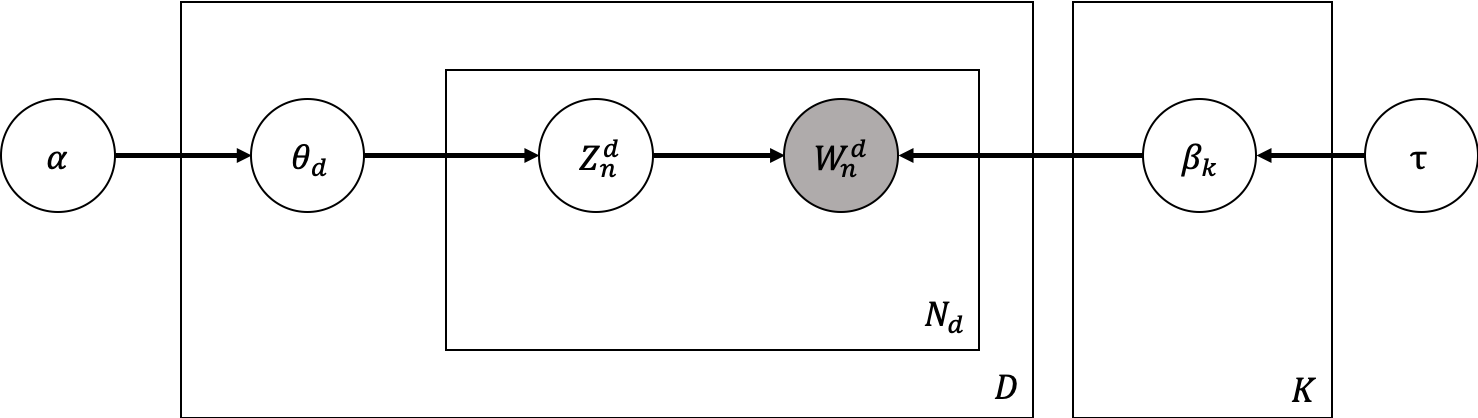

$\alpha$ is the proportions parameter and it controls the mean shape and sparsity of $\theta_d$, which is the per-document topic proportions. The case is the same for the per-corpus topic distributions $\beta_k$ which is also drawn from a Dirichlet distribution. It uses the parameter $\tau$ as the topic parameter that controls the mean shape and sparsity of $\beta_k$. These parameters are drawn for each document and each topic respectively. For each word we then draw a topic assignment $Z_{d,n}$ given the topic distribution for that document $\theta_d$. From this we then draw a word from a multinomial given $Z_{d,n}$ and $\beta_k$. This is the way that LDA assumes that the documents are generated, and the joint probability of the model can be written as:

$$p(\beta, \theta, \mathbf{z}, \mathbf{w})=\left(\prod_{i=1}^{K} p\left(\beta_{i} | \eta\right)\right)\left(\prod_{d=1}^{D} p\left(\theta_{d} | \alpha\right) \prod_{n=1}^{N} p\left(z^d_{n} | \theta_{d}\right) p\left(w^d_{n} | \beta_{1: K}, z^d_{n}\right)\right)$$

To reiterate $\beta_k$ is the word distribution of the topic k. $\theta$ is the topic proportions of a given document and $z$ is the topic assignment of a word in a document. The topic parameter $\tau$ and the proportions parameter $\alpha$ are prior knowledge that we have about the word distribution and the topic distributions respectively. There are different ways to choose these priors - we have them as vectors with equal probability for each word and each topic respectively. 

From the joint probability we cam then infer the probability distribution of the hidden variables $\beta$, $\theta$ and $z$ given the words we observe in the documents $p(\beta,\theta,z|w)$. This is intractable and we therefore use variational inference to approximate the posterior distribution. This means that we want to approximate this distribution using known distributions that are easier to compute, namely $q(\beta, \theta,z)$. Training the model parameters then boils down to minimizing the KL-divergence between the distributions p and q which corresponds to maximizing the ELBO.

Different algorithms is used for doing this variational inference, Pyro uses mean-field variational inference where we model each variable independently instead of modelling the joint probability that has multiple variables. This simplifies expression for the ELBO that we want to maximize, which is what we use Pyro for.

## LDA - Pyro implementation

The model will now be implemented using the probabalistic Python framework Pyro. We will use generative process as mentioned in the previous section.

Get the modifed data matrix, where the documents are of equal length.

In [37]:
import requests, io
r = requests.get('https://github.com/MikkelGroenning/MBML_project/blob/master/data/processed/upsampled_data.npy?raw=true')

data = np.load(io.BytesIO(r.content)).astype('int32')
data.shape

(32211, 1500)

The data consists of 32.211 speeches, each with a length of 1500 words. We therefore only look at a subset of the data.

In [38]:
data_sub = data[:100]
data_sub = np.vectorize({k:v for (k,v) in zip(np.unique(data_sub), np.arange(len(np.unique(data_sub))))}.get)(data_sub)

In [39]:
num_words = data_sub.max() + 1
num_topics = 25
num_docs = data_sub.shape[0]
num_words_per_doc = data_sub.shape[1]

With these things defined we can now make an LDA model.

In [40]:
def model(data=None, batch_size=None):
    """ Make a plate of size num_topics with name "topics" and define a variable "topic_words".
          This represents the phi above. Use the equivalent of a uniform distribution for it  """
    with pyro.plate("topics", num_topics):
        topic_words = pyro.sample("topic_words", dist.Dirichlet(torch.ones(num_words) / num_words))

    """ Make two (nested) plates in here. One over documents and one over words
          Documents, called "documents":
          The plate over the documents should hold a variable "doc_topics" representing the theta above.
            Use the equivalent of a uniform distribution for it.
          
          Words, called "words":
          The plate over words, should have a topic assignment for each word (z_{i,j} above) which 
            should be enumerated.
          The second variable should be the words themselves which should be drawn from the "topic_words"
            using the assigned z_{i,j} and the observed data.

     """
    with pyro.plate("documents", num_docs) as ind:
        if data is not None:
            with pyro.util.ignore_jit_warnings():
                assert data.shape == (num_words_per_doc, num_docs)
            data = data[:, ind]
        doc_topics = pyro.sample("doc_topics", dist.Dirichlet(torch.ones(num_topics)/ num_topics))
        with pyro.plate("words", num_words_per_doc):
            # We use sequential instead of parallel to save memory
            word_topics = pyro.sample("word_topics", dist.Categorical(doc_topics), infer={'enumerate': 'sequential'})
            data = pyro.sample("doc_words", dist.Categorical(topic_words[word_topics]), obs=data)

    return topic_words, data

Instead of enumerating parallel by creating an extra torch dimension we use sequential enumeration, this is not as cheap a solution but it does not require as much memory as it runs the entire model, guide pair once per sample value, but we can not parallelize the computation.

In [41]:
W_torch = torch.tensor(data_sub.T).long()
W_torch.shape
#del data

torch.Size([1500, 100])

Now we define a custom guide. Here we tell Pyro how to approximate the posterior distribution with $q(z)$.

In [ ]:
def my_local_guide(data=None, batch_size=None):
    topic_words_posterior = pyro.param(
            "topic_words_posterior",
            lambda: torch.ones(num_topics, num_words),
            constraint=constraints.positive)
    with pyro.plate("topics", num_topics):
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))
    
    doc_topics_posterior = pyro.param(
            "doc_topics_posterior",
            lambda: torch.ones(num_docs, num_topics),
            constraint=constraints.simplex)
    with pyro.plate("documents", num_docs, batch_size) as ind:
        pyro.sample("doc_topics", dist.Delta(doc_topics_posterior[ind], event_dim=1))

Finally, we train the model using a clipped Adam optimization.

In [42]:
pyro.clear_param_store()
guide = AutoGuideList(model)
guide.add(AutoDiagonalNormal(pyro.poutine.block(model, expose=['doc_topics'])))
guide.add(my_local_guide)  # automatically wrapped in an AutoCallable

guide = my_local_guide

elbo = TraceEnum_ELBO(max_plate_nesting=2)

optim = ClippedAdam({'lr': 0.05})
svi = SVI(model, guide, optim, elbo)

# Define the number of optimization steps
n_steps = 750

# do gradient steps
for step in range(n_steps):
    elbo = svi.step(W_torch, batch_size=2)
    if step % 25 == 0:
        #print('.', end='')
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 2495814.0
[25] ELBO: 2342502.0
[50] ELBO: 2273299.5
[75] ELBO: 2154569.2
[100] ELBO: 2301480.2
[125] ELBO: 2167745.8
[150] ELBO: 2364738.5
[175] ELBO: 2166736.8
[200] ELBO: 2270047.5
[225] ELBO: 2284502.2
[250] ELBO: 2392268.5
[275] ELBO: 2319224.5
[300] ELBO: 2340768.8
[325] ELBO: 2055330.8
[350] ELBO: 2295447.8
[375] ELBO: 2094273.1
[400] ELBO: 1899030.2
[425] ELBO: 2076325.0
[450] ELBO: 1838678.2
[475] ELBO: 1862525.6
[500] ELBO: 1909923.2
[525] ELBO: 1556724.2
[550] ELBO: 1648842.8
[575] ELBO: 1556491.5
[600] ELBO: 1555472.8
[625] ELBO: 1382575.2
[650] ELBO: 1334225.5
[675] ELBO: 1186297.4
[700] ELBO: 1303065.0
[725] ELBO: 982596.4


## Amortized LDA - Pyro Implementation

Since LDA is a model that contains latent variables what we really want is the is the posterior distribution of the latent variables conditioned on the observations. Because this model is somewhat complex doing exact inference is intractable. Therefore, variational inference is necessary and many different algorithms for doing variational inference exists, there is however some issues. Imagining that we use a Gaussian to approximate the posterior we would have to introduce two parameters for each observation (mean and variance) and then jointly optimize over these. This means that the number of parameters which we must optimize over grows as the number of observations grow and if we get new data, to do inference on we have to run the optimization again. To mitigate these problems what can be done instead is to introduce a parameterized function that maps from the observation space to the parameters of the approximate posterior distribution. This can be done by introducing a neural network that takes observations as input and gives the mean and variance parameters as output for the latent variable associated with that observation. It is then the parameters of the neural network that is optimized instead of the individual parameters of each observation. Since it is the parameters of the neural network which we optimize then number of parameters which we need to optimize is now constant. Also, if additional data is introduced all we need to approximate the posterior distributions of these new observations is to pass it through the network. It is not a free win, the approximate posterior one gets from the neural network is limited due to two factors, how well the variational distribution match the true posterior and the ability of the network to compute good parameters for each datapoint. Despite of these drawbacks we have decided to implement amortized variational inference because of the problems which we had running the mean-field variational inference.

In [43]:
layer_sizes = np.arange(98,103)
layer_sizes = torch.tensor(layer_sizes)
print(layer_sizes.size())

def make_predictor(num_words, layer_sizes):
    layer_sizes = ([num_words] +
                   [int(s) for s in torch.split(layer_sizes,1)] +
                   [num_topics])
    logging.info('Creating MLP with sizes {}'.format(layer_sizes))
    layers = []
    for in_size, out_size in zip(layer_sizes, layer_sizes[1:]):
        layer = nn.Linear(in_size, out_size)
        layer.weight.data.normal_(0, 0.001)
        layer.bias.data.normal_(0, 0.001)
        layers.append(layer)
        layers.append(nn.Sigmoid())
    layers.append(nn.Softmax(dim=-1))
    return nn.Sequential(*layers)

torch.Size([5])


And the guide

In [44]:
pyro.clear_param_store()

def parametrized_guide(predictor, data, batch_size=2):
    # Use a conjugate guide for global variables.
    topic_weights_posterior = pyro.param(
            "topic_weights_posterior",
            lambda: torch.ones(num_topics),
            constraint=constraints.positive)
    topic_words_posterior = pyro.param(
            "topic_words_posterior",
            lambda: torch.ones(num_topics, num_words),
            constraint=constraints.greater_than(0.5))
    with pyro.plate("topics", num_topics):
        pyro.sample("topic_weights", dist.Gamma(topic_weights_posterior, 1.))
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))

    # Use an amortized guide for local variables.
    pyro.module("predictor", predictor)
    with pyro.plate("documents", num_docs, batch_size) as ind:
        data = data[:, ind]
        # The neural network will operate on histograms rather than word
        # index vectors, so we'll convert the raw data to a histogram.
        counts = (torch.zeros(num_words, ind.size(0)).scatter_add(0, data, torch.ones(data.shape)))
        doc_topics = predictor(counts.transpose(0, 1))
        pyro.sample("doc_topics", dist.Delta(doc_topics, event_dim=1))

learning_rate = 0.05

predictor = make_predictor(num_words, layer_sizes)
guide = functools.partial(parametrized_guide, predictor)
# Elbo = JitTraceEnum_ELBO if args.jit else TraceEnum_ELBO
elbo = TraceEnum_ELBO(max_plate_nesting=2)
optim = ClippedAdam({'lr': learning_rate})
svi = SVI(model, guide, optim, loss=elbo)

# Define the number of optimization steps
n_steps = 1000

# do gradient steps
for step in range(n_steps):
    elbo = svi.step(W_torch, batch_size=2)
    if step % 25 == 0:
        #print('.', end='')
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 2494590.0
[25] ELBO: 2397545.0
[50] ELBO: 2331409.0
[75] ELBO: 2352269.5
[100] ELBO: 2317576.5
[125] ELBO: 2307803.8
[150] ELBO: 2259546.5
[175] ELBO: 2268330.0
[200] ELBO: 2291747.0
[225] ELBO: 2274246.5
[250] ELBO: 2302518.8
[275] ELBO: 2231454.2
[300] ELBO: 2142423.5
[325] ELBO: 2237889.5
[350] ELBO: 2304453.5
[375] ELBO: 2261855.8
[400] ELBO: 2173563.2
[425] ELBO: 2254130.0
[450] ELBO: 2270101.0
[475] ELBO: 2298247.8
[500] ELBO: 2218553.5
[525] ELBO: 2284694.0
[550] ELBO: 2269963.5
[575] ELBO: 2279396.5
[600] ELBO: 2224832.0
[625] ELBO: 2242702.8
[650] ELBO: 2298752.0
[675] ELBO: 2264577.0
[700] ELBO: 2261623.0
[725] ELBO: 2292505.5
[750] ELBO: 2295590.2
[775] ELBO: 2326499.5
[800] ELBO: 2235632.8
[825] ELBO: 2133800.0
[850] ELBO: 2234727.5
[875] ELBO: 2253021.2
[900] ELBO: 2197481.2
[925] ELBO: 2289784.0
[950] ELBO: 2326334.5
[975] ELBO: 2124050.5


## Pyro - Results

In [46]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=20,
                        return_sites=("topic_words",))
samples = predictive(W_torch)
samples["topic_words"].shape

ValueError: Shape mismatch inside plate('documents') at site word_topics dim -1, 100 vs 2
   Trace Shapes:            
    Param Sites:            
   Sample Sites:            
     topics dist      |     
           value   25 |     
topic_words dist   25 | 4086
           value   25 | 4086
  documents dist      |     
           value  100 |     
 doc_topics dist  100 |   25
           value    2 |   25
      words dist      |     
           value 1500 |     

In [ ]:
samples.keys()

In [ ]:
doc_topics_posterior = samples["topic_words"].mean(axis=0)
doc_topics_posterior.shape

In [ ]:
# Compute the argmax of the mean of all samples of topic for each document
#   this is the most likely topic for each document in our data
torch.argmax(doc_topics_posterior, axis=2)[0]

tensor([2105, 2105, 1549, 2105, 1549, 2105, 1549, 2105, 2027, 2105, 2105, 2105,
        2105, 2105, 2105, 2105, 2105, 2105, 1549, 1549, 2105, 2105, 2105, 1549,
        2027], grad_fn=<SelectBackward>)

In [19]:
from src.features.build_features import df, X, X_tfidf, vocabulary

In [20]:
x = [2105, 2105, 1549, 2105, 1549, 2105, 1549, 2105, 2027, 2105, 2105, 2105, 2105, 2105, 2105, 2105, 2105, 2105, 1549, 1549, 2105, 2105, 2105, 1549, 2027]
voc = list(vocabulary.keys())

for i in x:
    print(voc[i])

beliggen
beliggen
arh
beliggen
arh
beliggen
arh
beliggen
begæring
beliggen
beliggen
beliggen
beliggen
beliggen
beliggen
beliggen
beliggen
beliggen
arh
arh
beliggen
beliggen
beliggen
arh
begæring


## LDA on full data set using the Gensim Library
In this section of the notebook we will explore the topic that the politician in denmark talk about. As Pyro is to slow too slow in terms of handeling the full dataset we have utilied the Library Gensim. We have assumed that 25 topics exists in the dataset - note in praxis it is a difficult task to determine the appropriate number of topics - it usualy requires domain knowledge. 

More information about the Gensim Library can be found at https://radimrehurek.com/gensim/.

In [1]:
from wordcloud import WordCloud
from gensim.models import LdaModel
from gensim import corpora, similarities

from src.features.build_features import  vocabulary, X, X_tfidf, corpus, corpus_tfidf

The model can easily be trained using *LdaModel* from gensim. Note it will take approximately 10 minutes to run the script. 
(still far less than the Pyro model)

In [ ]:
# Flip vocabulary dictionary so that the format fit gensim
id2word = {v:k for v, k in sorted((value, key) for (key,value) in vocabulary.items())}

# Set training parameters.
num_topics = 25
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Train LDA model.
model = LdaModel(
    corpus=corpus_tfidf,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [2]:
# model.save("../gensim_lda_model.model")
model = LdaModel.load("../models/gensim_lda_model.model")
top_topics = model.top_topics(corpus, topn=50)

## LDA - Gensim Results

To visualize the results we print a cell below that generates a 5 by 5 grid with wordclouds. Each cloud corresponds to one of the 25 topics. The importance of the word within the topic are shown by the size of the word. Larger words meeans more relevance for that specific topic.

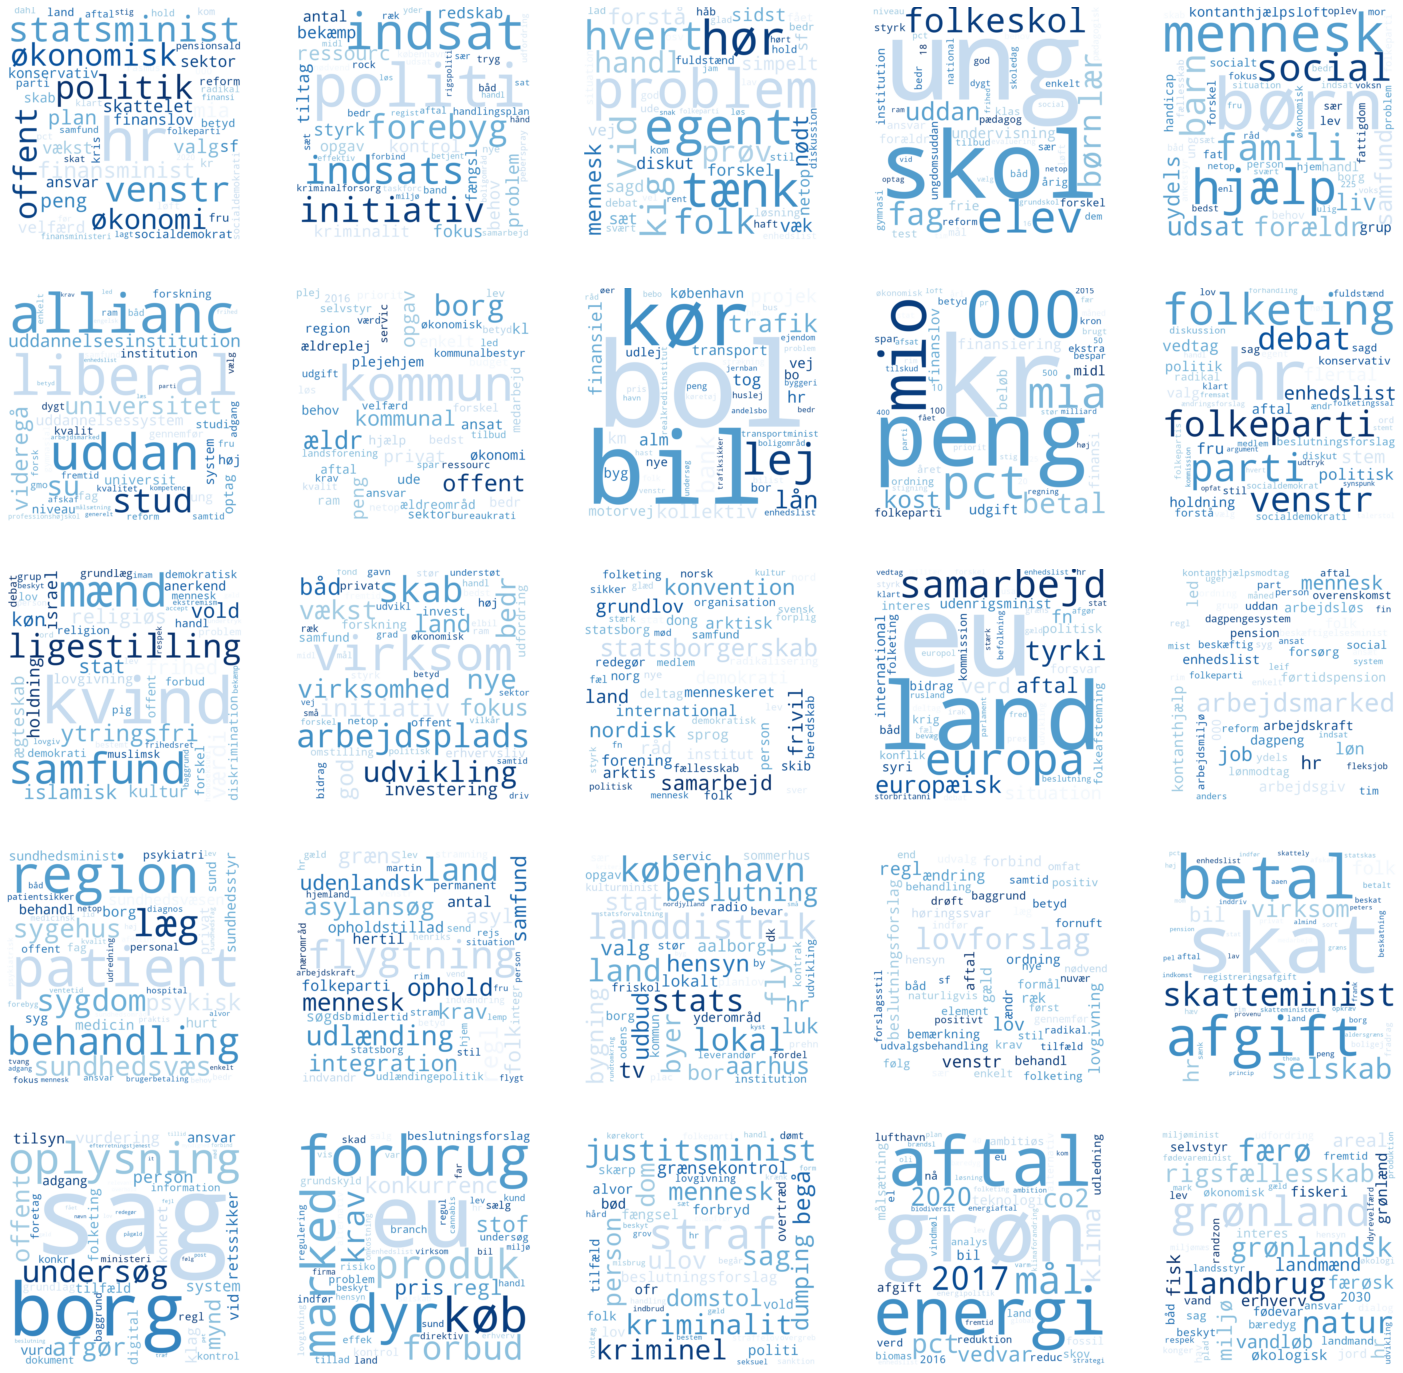

In [3]:
rows, cols = np.meshgrid(
    np.arange(5),
    np.arange(5)
)

rows = rows.flatten()
cols = cols.flatten()

f, axarr = plt.subplots(5,5, figsize=(25,25))

for i in range(25):
    word_frec = {word : weight for weight, word in top_topics[i][0]}

    wc = WordCloud( colormap='Blues',  
            background_color='white', 
            random_state=2,             
            width = 1000, 
            height=  1000 )
    wc.generate_from_frequencies(word_frec)

    axarr[rows[i],cols[i]].imshow(wc, interpolation='bilinear')
    axarr[rows[i],cols[i]].axis('off')
plt.show()

With a bit of knowledge of the Danish language and society it is clear that the model actually finds some topics that we as humans can recognize and see patterns within. It is seen that some of the topics just denote the language that politicians use in the parliament. Furthermore it seems that some components contains more than what we as human would consider one topic, such as the second last topic, clearly showing the topic being about sustainability. Perhaps some of the topics could be even more spicific by adding additional topics components, due to time constraints this has not been attempted. We will go into more detail of the results in the Dynamic Topic Model.

# Dynamic Topic Modelling

## Preprocessing

In [2]:
df = pd.read_pickle("data/processed/data.pickle")

with open("data/processed/vectorized.pickle", 'rb') as f:
    vocabulary, X, X_tfidf, corpus, corpus_tfidf = pickle.load(f)

del X
del X_tfidf
del corpus_tfidf

df.Starttid =pd.to_datetime(df.Starttid)

# Make a dictionary with id to word
id2word = {v:k for v, k in sorted((value, key) for (key,value) in vocabulary.items())}

# Dynamic Topic Modelling - Theory

Dynamic topic modelling (DTM) is an extension of LDA. It discovers topics like the LDA but it also discover their evolution trends in the time series data by using a Markov process. As the Dirichlet distribution is not suitable to model state changes, the DTM uses a logistic-normal parameterization. This allows for an evolution of the parameters with Gaussian noise. The Gaussian variables $\alpha$ and $\beta$ are then mapped to the plate from where multinomial variables are sampled. As the Gaussian and multinomial variables are non-conjugant, the exact inference of the model is intractable. This complicates things as it is not possible to marginalize out variables by integration. 

![dtm](https://raw.githubusercontent.com/MikkelGroenning/MBML_project/master/figures/dtm_fig.png "dtm")

The graphical representation of the DTM can be observed above. The same interpretation of the variables can be made as for the LDA. To recap, $\alpha$ is the proportion parameters, $\theta$ is the per-document topic proportions, $Z$ is the per-word topic assignments, $W$ is the observed words, $\beta$ is the topics. For the plates $D$ is the document plate, $N$ is the word plate and $K$ is the topic plate. Some additions to the model is that each of the variables is now evolved from time $t$, another addition is that as $\beta$, $\theta$ and $\alpha$ are now Gaussian a variance prior is assigned to each of them. The priors can be initialized from a Cauchy distribution. The generative process is then given as the following for a time slice $t$:

* Initialize $\sigma$, $\delta$ and $\psi$
* Draw topics $\beta_{t} | \beta_{t-1} \sim \mathcal{N}\left(\beta_{t-1}, \sigma^{2} I\right)$
* Draw $\alpha_{t} | \alpha_{t-1} \sim \mathcal{N}\left(\alpha_{t-1}, \delta^{2} I\right)$
* For each document:
    * Draw $\theta \sim \mathcal{N}\left(\alpha_{t}, \psi^{2} I\right)$
    * For each word:
        * Draw $z \sim \operatorname{Mult}(\pi(\theta))$
        * Draw $W_{t, d, n} \sim \operatorname{Mult}\left(\pi\left(\beta_{t, z}\right)\right)$

With $\pi(x)_i=\frac{\exp \left(x_i\right)}{\sum_{j \in w} \exp \left(x_j\right)}, \text{ for } i=1,\dots,w$ being a soft-max transformation to accomodate for the logits in the multinomial distributions.<br>

From the PGM above and given we have some observed data $\mathcal{D}$, the joint distribution can be found:
\begin{align}
p(\boldsymbol{\alpha}, \boldsymbol{\theta}, \boldsymbol{\beta}, \mathbf{Z}, \mathcal{D}, \delta, \sigma, \psi) = & \prod_{t=1}^{T} \mathcal{N}\left(\boldsymbol{\alpha}_{t} | \boldsymbol{\alpha}_{t-1}, \delta^{2} I\right)
\prod_{k=1}^{K} \mathcal{N}\left(\boldsymbol{\beta}_{k, t} | \boldsymbol{\beta}_{k, t-1}, \sigma^{2} I\right) \times \\ &\prod_{d=1}^{D_{t}} \mathcal{N}\left(\theta_{d, t} | \boldsymbol{\alpha}_{t}, \psi^{2} I\right)
\prod_{n=1}^{N_{d, t}} \operatorname{Mult}\left(Z_{d, n, t} | \pi\left(\boldsymbol{\theta}_{d, t}\right)\right) \times \\
&\operatorname{Mult}\left(W_{d, n, t} | \pi\left(\beta_{z_{d, n, t}, t}\right)\right)
\end{align}
It is then known that the posterior distribution is proportional to the joint distribution up to a normalization constant.
\begin{equation}
p(\boldsymbol{\alpha}, \boldsymbol{\theta}, \boldsymbol{\beta}, \mathbf{Z} | \mathcal{D}, \delta, \sigma, \psi) \propto p(\boldsymbol{\alpha}, \boldsymbol{\theta}, \boldsymbol{\beta}, \mathbf{Z}, \mathcal{D}, \delta, \sigma, \psi)
\end{equation}

This is a complex posterior distribution, doing mean-field variation approximation would be out of scope for this course, we therefore continue to the modelling.

# Dynamic Topic Modelling - Training

In this section we will create a dynamic topic model. To run the model binaries is required from https://github.com/magsilva/dtm/tree/master/bin and the model itself.

In [3]:
# path to dtm home folder
dtm_home = r"C:\Users\Christian\Desktop\dtm\dtm"
# path to the binary.
dtm_path = r"C:\Users\Christian\Desktop\dtm\bin\dtm-win64.exe"

The model is setup the same way as for the LDA, except we need to create time slices.

In [5]:
# Choose how much of the data you want
df_slice = df
corpus_slice = corpus

Creating time slices. A time slice is simply a sequence of time steps, indicating the time of the document.

In [91]:
def convert_to_yearmonth(x, y):
    return x*100+y

def get_slice(df_slice, type_slice="halfyear"):
    """Choose which time slice you want to train with."""
    yearmonth=[]
    years= df_slice.Starttid.dt.year
    months =  df_slice.Starttid.dt.month
    n=len(df_slice.Starttid.dt.year)
    for i in range(n):
        yearmonth.append(convert_to_yearmonth(years[i], months[i]))
            
    if(type_slice=="year"):
        # Create time slices (YEARS)
        unique_label, time_slices = np.unique(years, return_counts=True) 
    
    if(type_slice=="month"):
        # Create time slices (YEARS, MONTH)
        unique_label, time_slices = np.unique(yearmonth, return_counts=True) 

    # every half year
    if(type_slice=="halfyear"):
        unique_label = []
        time_slices = []
        unique_label_month, time_slices_month = np.unique(yearmonth, return_counts=True)
        for i in range(len(uniquemonths)):
            if i % 6 == 0:
                unique_label.append(unique_label_month[i])
                size_left = ((len(unique_label_month)-1)-i)
                if size_left<6: #burde stå 6 her
                    temp = sum(time_slices_month[i:])
                else:
                    temp=sum(time_slices_month[i:(i+6)])
                time_slices.append(temp)
    return unique_label, time_slices 

unique_label, time_slices = get_slice(df,type_slice="halfyear")        

Now we can train the model. It takes approximately 5-6 hours. It is a lot longer than the Gensim LDA model, but it is also a more complex a model.

In [15]:
num_topics = 25

training=False
if training == True:
    t = time.time()
    model = DtmModel(dtm_path, corpus=corpus_slice, id2word=id2word, num_topics=num_topics, time_slices=time_slices)
    print("Done in %.2f seconds" % (time.time() - t))

save_me=False
if save_me == True:
    model.save('dtm.gensim')

Done in 20443.35 seconds


In [14]:
model=DtmModel.load("dtm.gensim")

# Dynamic Topic Modelling - Results

In [96]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis
pyLDAvis.enable_notebook()

First let us get an overview of the topics. To do this we use a LDA wrapper from the package pyLDAvis. It allows us to see each topic, the term relevance, the conditional distribution of a term, the marginal distributions using multidimensional scaling and finally the estimated and overall frequencies of the terms. The adjustable relevance metric only works when a topic has been selected.

In [95]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=0, corpus=corpus)

In [271]:
''' !NOTE! Your icons may disappear in jupyter notebook/lab when running this, 
 this is a current bug: https://github.com/microsoft/vscode-python/issues/8946.
 To make them reappear simply make the plot disappear by outcommenting the code 
 using # and run the cell, then they reappear. '''

vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

In the above visualization there is a lot of information, so we will take it in steps. First, to the left for the "Intertopic Distance Map", the distances between the topics are mapped onto two principal components to enable the visualization. The bubbles indicate the overall prevalence given by the marginal distribution, looking at topic 1, which has a large marginal topic distribution, contains a lot of common high frequency words, such as `folketing` and `debat`. Smaller topics seem to contain more specific subjects, such as topic 21, which is about healthcare. <br>

The distance between the marginal topic distributions represents how similar each topic is to other topics. As an example look at topic 14 and 13. 13 contains the words `ban`, `drug`, `problem` and 14 is about `burka`, `women`, `free speech`, `democracy` and `afghanistan`. All hotly debated subjects in Denmark and the word `ban` might be used in the context of subjects from topic 14, making the distance between them smaller.<br>

To the right we see a list of most relevant terms for a given topic. Hovering over one of the words the conditional distribution of that specific word is seen in the visualization to the left. The relevance metric in the top is given by

$$
\text{relevance}(w | t) = \lambda p(w | t)+(1-\lambda) \frac{p(w | t)}{p(w)}
$$
With $w$ being the term/word and $t$ the topic. We see making $\lambda$ close to 1 will emphasize the conditional distribution of the word given the topic, but decreasing $\lambda$ will divide the conditional distribution with the term's marginal distribution. This means terms with a large marginal distribution will get penalized. As words with large marginal distribution is usually not very interesting common words, decreasing $\lambda$ can make more interesting and rare words appear. In the following paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf a $\lambda=0.6$ is found to be a rule of thumb.<br>

Finally, we also see the frequency of each of the terms, the blue bars represent the overall term frequency (proportional to $\mathrm{p}( w )$ ) and the red bars the estimated term frequency within the selected topic (proportional to $\mathrm{p}( w | t )$ ). The topics with a large marginal distribution (higher than 5% of tokens) seem to be common words often said during meetings, while the topics with smaller distribution are more interesting in regards of specific subjects or topics. <br>

The visualization above does not show the evolution of topics. To show this we will choose some specific topics. First we attempt to put an main prevalence label on each topic, this is done by just looking at the topics, so do not rely too much on them.

**Topic labels**:<br>
0. Healthcare, 1:requirements(?), 2:National Economy, 3:case, 4:crime, 5:traffic, 6:private market, 7:Syria crisis and immigration, 8:Politics (perhaps right oriented), 9:climate, 10:parties and election, 11: jobs, 12:pension, 13:kids and school, 14:war and crisis, 15:bans, 16:elder care, 17: legislation, 18:money, 19:residential, 20:university and young people, 21: collaboration, 22:society, 23:europe, 24:agriculture

Now let us simply look at how the terms change within some of the chosen topics over time.

In [93]:
"""Get a dataframe with the top n terms in the topic for each of
    the given time slices."""
def term_table(time_slice_labels, topic, slices, topn=10):
    data = {}
    for time_slice in slices:
        time = time_slice_labels.index(time_slice)
        data[time_slice] = [
            term for p, term
            in model.show_topic(topic, time=time, topn=topn)
        ]
    return pd.DataFrame(data) 


In the header we see the dates, as the time slices for the model is based on half a year we see increments of 6 months. The first 4 numbers represent the year and the last two the month. For topic 5, we see a lot about collective traffic, but around 2012 we see a sharp rise in interest of rural areas, perhaps due to agriculture and an idea of moving more jobs out of Copenhagen.

In [217]:
top_term_table(time_slice_labels=unique_label, topic=5, slices=unique_label, topn=6)

,200910,201004,201011,201105,201201,201208,201302,201310,201404,201411,201505,201601,201608,201702
0,folkeparti,folkeparti,venstr,venstr,venstr,venstr,venstr,venstr,folketing,folketing,folketing,folketing,parti,parti
1,folketing,folketing,folkeparti,folketing,folketing,folketing,folketing,folketing,venstr,parti,parti,parti,folketing,folketing
2,venstr,venstr,folketing,folkeparti,folkeparti,parti,enhedslist,enhedslist,parti,venstr,enhedslist,debat,debat,debat
3,debat,debat,debat,debat,debat,debat,parti,parti,enhedslist,enhedslist,debat,liberal,liberal,liberal
4,parti,parti,parti,parti,parti,folkeparti,debat,debat,debat,debat,venstr,enhedslist,allianc,egent
5,stem,stem,stem,stem,enhedslist,enhedslist,folkeparti,folkeparti,folkeparti,liberal,liberal,allianc,egent,allianc


For topic 7 initially there is a lot of interest in conventions, probably the human rights conventions due to the crisis in syria. After the crisis we see an increase in humans, especially refugees, indicating the refugee crisis in Europe.

In [192]:
top_term_table(time_slice_labels=unique_label, topic=7, slices=unique_label, topn=6)

,200910,201004,201011,201105,201201,201208,201302,201310,201404,201411,201505,201601,201608,201702
0,opholdstillad,konvention,konvention,konvention,konvention,konvention,land,land,land,flygtning,flygtning,flygtning,flygtning,land
1,konvention,opholdstillad,land,land,land,land,udlænding,udlænding,mennesk,land,land,land,land,flygtning
2,land,land,udlænding,udlænding,udlænding,udlænding,konvention,mennesk,flygtning,mennesk,mennesk,mennesk,mennesk,mennesk
3,folkeparti,folkeparti,folkeparti,folkeparti,folkeparti,statsborgerskab,statsborgerskab,asylansøg,udlænding,asylansøg,situation,græns,græns,græns
4,udlænding,udlænding,opholdstillad,statsborgerskab,statsborgerskab,folkeparti,asylansøg,ophold,asylansøg,statsborgerskab,folk,folk,udlænding,udlænding
5,karst,statsborgerskab,statsborgerskab,regl,regl,mennesk,ophold,konvention,statsborgerskab,udlænding,statsborgerskab,statsborgerskab,statsborgerskab,statsborgerskab


For topic 9 we see much talk about banks and financials, this would make sense as 2009 is during the financial crisis. We see a few years later the interest of green energy, adaptions and a green tax.

In [172]:
top_term_table(time_slice_labels=unique_label, topic=9, slices=unique_label, topn=6)

,200910,201004,201011,201105,201201,201208,201302,201310,201404,201411,201505,201601,201608,201702
0,bank,bank,bank,bank,bank,bank,bank,grøn,grøn,grøn,grøn,grøn,grøn,grøn
1,finansiel,finansiel,finansiel,finansiel,finansiel,finansiel,finansiel,bank,energi,afgift,afgift,afgift,afgift,bil
2,energi,energi,energi,energi,energi,energi,energi,energi,bank,energi,bil,omstilling,omstilling,afgift
3,klima,klima,klima,stat,grøn,grøn,grøn,finansiel,finansiel,bank,energi,energi,bil,omstilling
4,vedvar,vedvar,stat,grøn,stat,virksom,virksom,virksom,afgift,bil,omstilling,bil,energi,energi
5,stat,stat,vedvar,klima,aftal,aftal,aftal,aftal,land,land,land,land,aftal,aftal


In topic 11 in general we see a strong interest in the job market. Also women and unemployness.

In [174]:
top_term_table(time_slice_labels=unique_label, topic=11, slices=unique_label, topn=6)

,200910,201004,201011,201105,201201,201208,201302,201310,201404,201411,201505,201601,201608,201702
0,arbejdsmarked,arbejdsmarked,arbejdsmarked,arbejdsmarked,kvind,led,led,arbejdsmarked,arbejdsmarked,arbejdsmarked,arbejdsmarked,arbejdsmarked,arbejdsmarked,arbejdsmarked
1,led,led,led,kvind,arbejdsmarked,kvind,arbejdsmarked,kvind,kvind,kvind,kvind,kvind,kvind,kvind
2,kvind,kvind,kvind,led,led,arbejdsmarked,kvind,led,dagpeng,dagpeng,arbejdsgiv,mænd,mænd,pensionsald
3,arbejdsløs,arbejdsløs,arbejdsløs,arbejdsløs,arbejdsløs,arbejdsløs,arbejdsløs,arbejdsløs,led,led,dagpeng,arbejdsgiv,arbejdsgiv,mænd
4,bjarn,efterløn,efterløn,efterløn,mennesk,dagpeng,dagpeng,dagpeng,arbejdsløs,arbejdsløs,led,led,led,led
5,lausts,dagpeng,dagpeng,mennesk,dagpeng,mennesk,mennesk,mennesk,dagpengesystem,arbejdsgiv,mænd,dagpeng,pensionsald,arbejdsgiv


Topic 14 is about wars and crisis. First we see Afghanistan and the burka being a hotly debated subject. Later the civil war in Syria starts. Isil appear and Tyrkey is discussed a lot based in the refugee crisis. At the end we see Russia appear, perhaps as they took action against Isil and entered Syria.

In [175]:
top_term_table(time_slice_labels=unique_label, topic=14, slices=unique_label, topn=6)

,200910,201004,201011,201105,201201,201208,201302,201310,201404,201411,201505,201601,201608,201702
0,land,land,land,land,land,land,forsvar,land,land,land,tyrki,tyrki,tyrki,tyrki
1,kvind,ytringsfri,ytringsfri,ytringsfri,ytringsfri,forsvar,land,forsvar,syri,tyrki,land,land,land,land
2,ytringsfri,afghanistan,demokrati,demokrati,forsvar,ytringsfri,ytringsfri,krig,isil,syri,syri,syri,syri,situation
3,afghanistan,kvind,afghanistan,forsvar,demokrati,verd,soldat,soldat,forsvar,situation,stat,stat,situation,religiøs
4,burka,demokrati,soldat,verd,verd,demokrati,krig,enhedslist,situation,isil,situation,situation,stat,udenrigsminist
5,demokrati,forsvar,forsvar,afghanistan,krig,krig,verd,syri,enhedslist,krig,krig,krig,krig,rusland


In topic 21 we see collaborations within the realm. Especially between Greenland and Faroe Islands.

In [185]:
top_term_table(time_slice_labels=unique_label, topic=21, slices=unique_label, topn=6)

,200910,201004,201011,201105,201201,201208,201302,201310,201404,201411,201505,201601,201608,201702
0,land,land,land,land,land,grønland,grønland,grønland,grønland,grønland,grønland,grønland,grønland,grønland
1,nordisk,nordisk,nordisk,nordisk,grønland,land,land,samarbejd,færø,færø,færø,færø,færø,færø
2,samarbejd,samarbejd,samarbejd,grønland,nordisk,nordisk,samarbejd,nordisk,samarbejd,grønlandsk,grønlandsk,grønlandsk,grønlandsk,grønlandsk
3,færø,færø,grønland,samarbejd,samarbejd,samarbejd,nordisk,land,nordisk,samarbejd,rigsfællesskab,rigsfællesskab,rigsfællesskab,samarbejd
4,grønland,grønland,færø,færø,færø,færø,færø,færø,land,land,samarbejd,samarbejd,samarbejd,land
5,udenrigsminist,udenrigsminist,udenrigsminist,udenrigsminist,udenrigsminist,grønlandsk,grønlandsk,grønlandsk,grønlandsk,rigsfællesskab,land,land,land,rigsfællesskab


Topic 24 is about agriculture, environment and nature. We see over the years nature takes the position of agriculture as the main debated term.

In [177]:
top_term_table(time_slice_labels=unique_label, topic=24, slices=unique_label, topn=6)

,200910,201004,201011,201105,201201,201208,201302,201310,201404,201411,201505,201601,201608,201702
0,landbrug,landbrug,landbrug,landbrug,landbrug,landbrug,landbrug,natur,natur,natur,natur,natur,natur,natur
1,natur,natur,natur,natur,natur,natur,natur,landbrug,landbrug,landbrug,landbrug,landbrug,landbrug,landbrug
2,grøn,erhverv,erhverv,erhverv,erhverv,erhverv,erhverv,erhverv,erhverv,miljø,miljø,miljø,miljø,miljø
3,erhverv,grøn,grøn,miljø,landmænd,fisk,fisk,fisk,miljø,erhverv,skov,areal,areal,areal
4,miljø,miljø,miljø,grøn,miljø,landmænd,miljø,miljø,fisk,landmænd,areal,vandløb,vandløb,vandløb
5,vækst,vækst,landmænd,landmænd,fisk,miljø,landmænd,landmænd,landmænd,areal,erhverv,skov,landbrugspak,landbrugspak


The above topics are the ones we found interesting. To help us choose some interesting terms the variance can be used. Terms with higher variance are usually more interesting, as they fluctuate more over time. We will omit the results here, but simply let the reader know that based on the variance and the tables above, we have chosen some topics to see how they fluctuate over time.

In [214]:
def term_variance(topic, word2id, model):
    """Find variance of probability over time for terms of a given topic."""
    p = np.exp(model.lambda_[topic]) / np.exp(model.lambda_[topic]).sum(axis=0)
    variances = np.var(p, axis=1)
    order = np.argsort(variances)[::-1]
    terms = np.array([term for term, _
                    in sorted(word2id.items(),
                              key=lambda x: x[1])])[order]
    variances = variances[order]
    return list(zip(terms, variances))
term_variance(14, vocabulary, model)[0:6]

[('tyrki', 4.593449455248251e-05),
 ('syri', 1.0363503932393604e-05),
 ('kvind', 5.9934697843382575e-06),
 ('afghanistan', 5.722432904508767e-06),
 ('ytringsfri', 5.129064342634612e-06),
 ('isil', 4.680556753638331e-06)]

Now let us see how the term probability varies over time.

In [186]:
def term_distribution(term, topic, word2id, model):
    """Extracts the probability over each time slice of a term/topic
    pair."""
    word_index = word2id[term]
    topic_slice = np.exp(model.lambda_[topic])
    topic_slice = topic_slice / topic_slice.sum(axis=0)
    return topic_slice[word_index]

In [259]:
def plot_term_evolution(topic, terms, id2word, model, time_slice, title=None, name=None):
    """Creates a plot of term probabilities over time in a given topic."""
    fig, ax = plt.subplots()
    plt.style.use('seaborn-white')
    count=0
    colors= ['b','g','r','c','m','y','k','darkgreen','maroon','darkblue']
    for term in terms:
        ax.plot(
            time_slice, term_distribution(term, topic, id2word, model),
            label=term, color=colors[count])
        count+=1
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yticklabels([])
    ax.set_ylabel('Probability')
    ax.set_xlabel('Date')
    if title:
        ax.set_title(title)
    if name:
        fig.savefig(
            name, dpi=300, bbox_extra_artists=(leg,), bbox_inches='tight')
    return fig, ax

For topic 5. Traffic is less debated, land districts and some project seems to be on the rise.

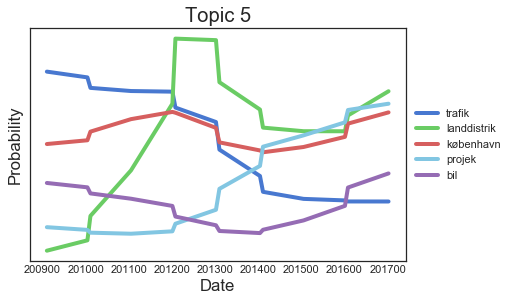

In [262]:
plot_term_evolution(5, ["trafik", "landdistrik", "københavn", "projek", "bil"], vocabulary, model, unique_label, title="Topic 5");

For topic 7. We see indeed Syria is a very debated term from 2010-2012, after this the refugee crisis kicks off, integration and refugees are now the main interest.

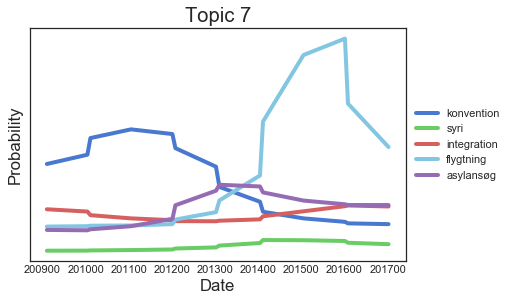

In [263]:
plot_term_evolution(7, ["konvention", "syri", "integration", "flygtning", "asylansøg"], vocabulary, model, unique_label, title="Topic 7");

For topic 9. The financial crisis is on-going, banks are a very debated term. When the financial crisis slows down the climate is in focus. Green adaption, green tax, green energy.

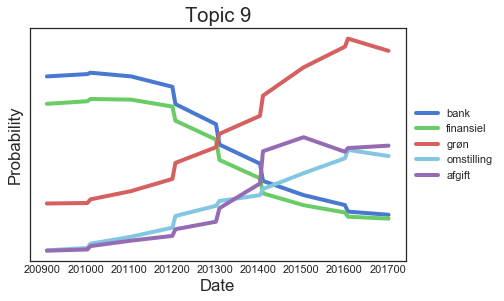

In [264]:
plot_term_evolution(9, ["bank", "finansiel", "grøn", "omstilling", "afgift"], vocabulary, model, unique_label, title="Topic 9");

For topic 11. We see the job market and women slowly increases.

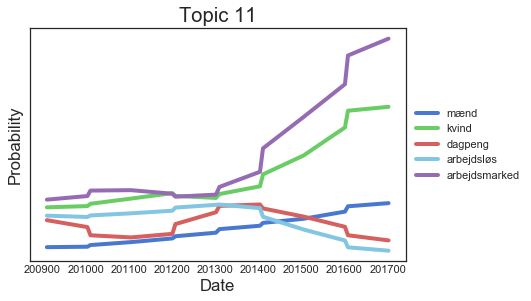

In [265]:
plot_term_evolution(11, ["mænd", "kvind", "dagpeng", "arbejdsløs", "arbejdsmarked"], vocabulary, model, unique_label, title="Topic 11");

For Topic 14. The war in afghanistan is slowly being a less debated subject. The war in Syria starts and interest in Tyrkey increases by a lot, probably due to the refugee crisis. At the end Russia is also increasing, maybe due to their presence in Syria.

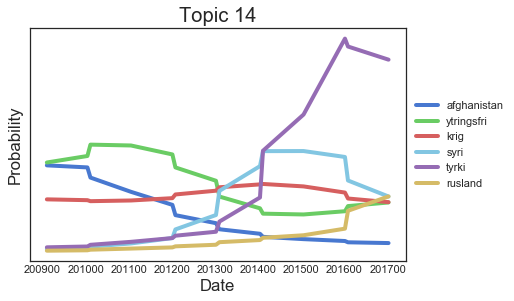

In [266]:
plot_term_evolution(14, ["afghanistan","ytringsfri", "krig", "syri", "tyrki", "rusland"], vocabulary, model, unique_label, title="Topic 14");

For topic 21. Faroe Island and Greenland is debated a lot.

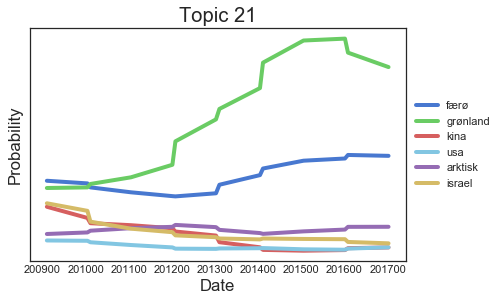

In [267]:
plot_term_evolution(21, ["færø", "grønland", "kina", "usa", "arktisk", "israel"], vocabulary, model, unique_label, title="Topic 21");

For topic 24. The focus on agriculture turns over to a focus on nature. "Landbrugspakken" is introduced.

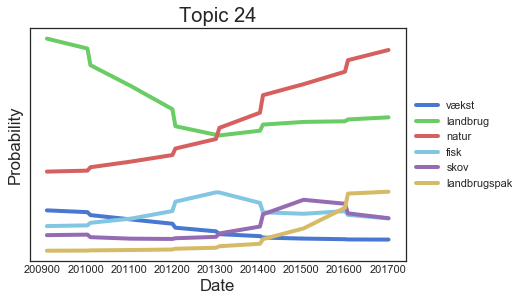

In [268]:
plot_term_evolution(24, ["vækst", "landbrug", "natur", "fisk", "skov", "landbrugspak"], vocabulary, model, unique_label, title="Topic 24");

Finally for topic 10, we will look at each party. Topic 10 seems to have some relation with the election. We see most right oriented parties are declining. Speeches including alternativet and socialdemokratiet are on the rise. 

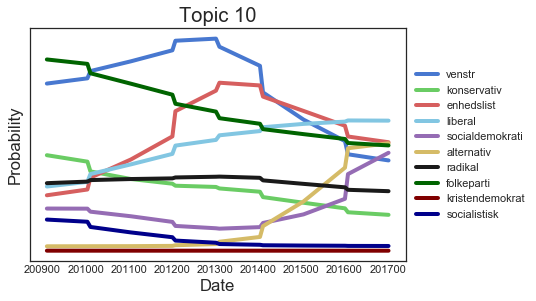

In [269]:
plot_term_evolution(10, ["venstr", "konservativ", "enhedslist", "liberal", "socialdemokrati", "alternativ","radikal", "folkeparti", 'kristendemokrat','socialistisk'], vocabulary, model, unique_label, title="Topic 10");

# Discussion

# Conclusion and future work

It was possible to extract meaningful topics from the <br>

In future work it would have been interesting to investigate N-grams, we do have topics that could easily be connected such as `Green` and `Energy`. Another thing would be to 
correlation

# Sources

https://medium.com/@jonathan_hui/machine-learning-latent-dirichlet-allocation-lda-1d9d148f13a4

https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf